In [3]:
from helpers import *
import numpy as np

#sns.set_palette('colorblind')
sns.set_style('whitegrid')
sns.set_palette("colorblind")

mpl.rcParams["axes.titlesize"] = 12.
mpl.rcParams["axes.labelsize"] = 12.
mpl.rcParams["axes.titleweight"] = "bold"
mpl.rcParams["axes.labelweight"] = "bold"
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = "serif"
mpl.rcParams['font.weight'] = "bold"

metrics = [
    "Metrics/EpRet",  # normalize: PPO
    "Metrics/EpCost",  # normalize: cost threshold/limit
    "Metrics/EpCumCostViolation"  # normalize: CPO as baseline
]

df = load_benchmark_data(load_ppo=True).sort_values(by="algo")
df["algo"]

We have a EmptyDataError for SafetyHumanoidVelocity-v1/ipo/seed-4000-2024-11-21-09-26-48.
We have a EmptyDataError for SafetyHumanoidVelocity-v1/ipo/seed-3000-2024-11-21-09-26-48.
We have a EmptyDataError for SafetyHumanoidVelocity-v1/ipo/seed-2000-2024-11-21-09-26-48.
We have a EmptyDataError for SafetyHumanoidVelocity-v1/ipo/seed-1000-2024-11-21-09-26-43.
We have a EmptyDataError for SafetyHumanoidVelocity-v1/ipo/seed-000-2024-11-21-09-26-43.
We have a EmptyDataError for SafetyHumanoidVelocity-v1/p3o/seed-1000-2024-11-20-14-31-48.
We have a EmptyDataError for SafetyHumanoidVelocity-v1/p3o/seed-2000-2024-11-20-14-31-48.
We have a EmptyDataError for SafetyHumanoidVelocity-v1/p3o/seed-4000-2024-11-20-14-36-28.
We have a EmptyDataError for SafetyHumanoidVelocity-v1/p3o/seed-3000-2024-11-20-14-36-29.
We have a EmptyDataError for SafetyHumanoidVelocity-v1/p3o/seed-000-2024-11-20-14-31-48.
We have a EmptyDataError for SafetyHumanoidVelocity-v1/p3o/seed-4000-2024-11-20-14-31-48.
We have a Em

219999    C-TRPO (ours)
209999    C-TRPO (ours)
219996    C-TRPO (ours)
219995    C-TRPO (ours)
219994    C-TRPO (ours)
              ...      
89161               PPO
89162               PPO
89163               PPO
89133               PPO
164998              PPO
Name: algo, Length: 220000, dtype: category
Categories (11, object): ['C-TRPO (ours)', 'TRPO-Lag', 'P3O', 'PCPO', ..., 'CPPO-PID', 'PPO-Lag', 'IPO', 'PPO']

In [4]:
import scipy


normalized_score_dict = {}

for metric in metrics:
    normalized_score_dict[metric] = {}
    for algo in ALGOS:
        normalized_score_dict[metric][algo] = np.zeros((5, len(ENVS)))
        for i, env in enumerate(ENVS):
            df_filtered = df[df["Train/TotalSteps"] == 10000000]
            df_filtered = df_filtered[df_filtered["env"] == env]
            if metric == "Metrics/EpRet":
                norm = df_filtered[df_filtered["algo"]=="PPO"][metric].mean()
                bias = 0
            elif metric == "Metrics/EpCost":
                norm = 25.0
                bias = - 1
            else:  # "Metrics/EpCumCostViolation"
                norm = scipy.stats.trim_mean(df_filtered[df_filtered["algo"]=="CPO"][metric], proportiontocut=0.25, axis=None)
                bias = 0
            data = np.array(df_filtered[df_filtered["algo"]==algo][metric])
            if not data.size == 0:
                normalized_score_dict[metric][algo][:len(data),i] = data / norm + bias
            else:
                print(f"Warning: empty data for {algo}, {env}")

normalized_score_dict


{'Metrics/EpRet': {'C-TRPO (ours)': array([[ 0.59820689,  0.42669984,  0.9605135 ,  0.80620919,  0.04316574,
           0.75826387,  0.83206393,  1.7026695 ],
         [ 0.55539136,  0.42305759,  0.95604577,  0.92818465,  0.07069733,
           0.63052273,  0.69804277,  0.34739117],
         [ 0.55717952,  0.39839798,  0.8392413 ,  0.92704001,  0.05919229,
           0.75986811,  0.73684746, 10.95883726],
         [ 0.55591389,  0.42372691,  0.89605844,  0.2329602 ,  0.06119686,
           0.74534   ,  0.75154124,  0.71654115],
         [ 0.56498532,  0.41178906,  0.90554973,  0.91518262,  0.07429558,
           0.67918351,  0.6163024 ,  0.666305  ]]),
  'TRPO-Lag': array([[ 5.66287813e-01,  4.29752196e-01,  8.30013821e-01,
           7.85352124e-01, -2.72836381e-02,  4.27192464e-01,
           8.36426662e-01,  3.17467797e-01],
         [ 6.00350655e-01,  4.12642608e-01,  8.86571756e-01,
           2.33613340e-01,  2.74995479e-02,  8.42038409e-01,
           8.70760727e-01,  8.40006327

In [5]:
from rliable import library as rly
from rliable import metrics as rl_metrics
from rliable import plot_utils

aggregate_scores, aggregate_score_cis = {}, {}

metric_names = [
    "Reward", 
    "Final Cost", 
    "Cumulative Cost"
]

metrics = [
    "Metrics/EpRet",  # normalize: PPO
    "Metrics/EpCost",  # normalize: cost threshold/limit
    #"eval_reward",
    #"eval_cost",
    "Metrics/EpCumCostViolation"  # normalize: CPO as baseline
]

for metric, metric_name in zip(metrics, metric_names):
    aggregate_scores[metric_name], aggregate_score_cis[metric_name] = rly.get_interval_estimates(
        normalized_score_dict[metric], 
        rl_metrics.aggregate_iqm, 
        reps=50000
    )

In [6]:
as_df = pd.DataFrame(aggregate_scores).melt(ignore_index=False).reset_index()
as_df = as_df.rename(columns={"index": "algo", "variable": "metric"})

as_ci_df = pd.DataFrame(aggregate_score_cis).melt(ignore_index=False).reset_index()
as_ci_df = as_ci_df.rename(columns={"index": "algo", "variable": "metric", "value": "ci"})
as_ci_df


,algo,metric,ci
0,C-TRPO (ours),Reward,"[[0.6009356239319791], [0.7064751809762873]]"
1,TRPO-Lag,Reward,"[[0.5144593635261118], [0.6754604809805583]]"
2,P3O,Reward,"[[0.4016957924640583], [0.5047479792213152]]"
3,PCPO,Reward,"[[0.3989410973343191], [0.48858444073032703]]"
4,CPO,Reward,"[[0.6352682931607319], [0.7295947826930672]]"
5,CUP,Reward,"[[0.5943475899295358], [0.700868168808067]]"
6,FOCOPS,Reward,"[[0.5635724295640748], [0.6672581244891486]]"
7,CPPO-PID,Reward,"[[0.4593131327526217], [0.5683002230426691]]"
8,PPO-Lag,Reward,"[[0.41656524085734664], [0.5138581713679723]]"
9,IPO,Reward,"[[0.3697073463958012], [0.4876324380863663]]"


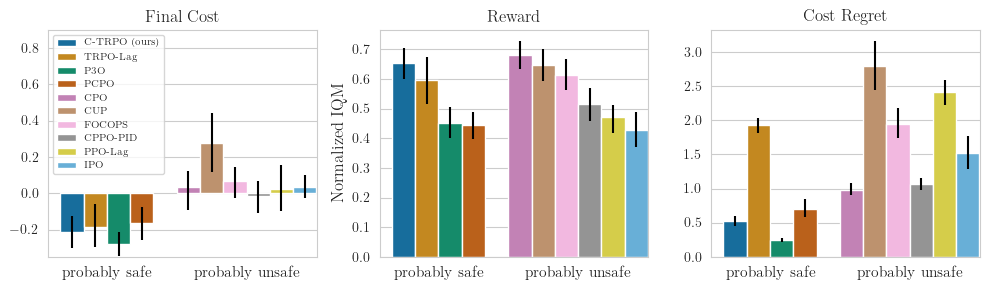

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(10, 3), sharey=False)

for metric_name, ax in zip([metric_names[1], metric_names[0], metric_names[2]], axs):
    sns.barplot(as_df[as_df["metric"] == metric_name], y="value", hue="algo", errorbar=("ci", False), ax=ax)

    bars = [rect for rect in ax.get_children() if isinstance(rect, mpl.patches.Rectangle)]
    for bar, algo in zip(bars, ALGOS):
        if np.array(as_ci_df[(as_ci_df["metric"] == "Final Cost") & (as_df["algo"] == algo)]["ci"])[0][1, 0] > 0:
            # bar.set_alpha(0.5)
            bar.xy = bar.xy[0] + 0.08, bar.xy[1]
    x = np.array(list(sorted([bar.xy[0] for bar in bars[:10]])))
    y = np.array(as_df[as_df["metric"] == metric_name]["value"])
    yerr = np.stack(as_ci_df[as_df["metric"] == metric_name]["ci"])[:,:,0].transpose()
    ax.errorbar(x=x+bars[0].get_width()/2, y=y, yerr=abs(yerr - y), fmt=' ', color="black")
    ax.set_ylabel("Normalized IQM" if metric_name == "Reward" else "")
    ax.set_title(metric_name)
    ax.set_xticks([bars[2].xy[0], bars[7].xy[0]])
    ax.set_xticklabels(["probably safe", "probably unsafe"], size=11)

# axs[1].plot([-0.41, 0.42], [1, 1], color="red", linestyle="dashed", label="limit", zorder=10)

handles, labels = axs[1].get_legend_handles_labels()

axs[0].legend([],[], frameon=False)
axs[1].legend([],[], frameon=False)
axs[2].legend([],[], frameon=False)

axs[0].set_title("Final Cost")
axs[1].set_title("Reward")
axs[2].set_title("Cost Regret")
axs[0].set_ylim(-0.35, 0.9)

axs[0].legend(handles, labels, prop={'size': 7})

plt.tight_layout()

plt.savefig(os.path.join("..", "graphics", f"benchmark.pdf"), dpi=600)

In [6]:
import numpy as np

metrics = [
    "Metrics/EpRet",  # normalize: PPO
    "Metrics/EpCost",  # normalize: cost threshold/limit
    "Metrics/EpCumCostViolation"  # normalize: CPO as baseline
]

normalized_score_dict_samples = {}

steps = np.array(range(1, 11))*1_000_000

for i, env in enumerate(ENVS):
    normalized_score_dict_samples[env] = {}
    for metric in metrics:
        normalized_score_dict_samples[env][metric] = {}
        for algo in ALGOS:
            normalized_score_dict_samples[env][metric][algo] = np.zeros((5, 10))
            for j, step in enumerate(steps):
                # display(df_filtered)
                df_filtered = df[df["env"] == env]
                data = np.array(df_filtered[(df_filtered["algo"]==algo) & (df_filtered["Train/TotalSteps"] == step)][metric])
                if not data.size == 0:
                    normalized_score_dict_samples[env][metric][algo][:,j] = data
                else:
                    print(f"Warning: empty data for {algo}, {env}")

this takes a couple minutes to run:

In [7]:
import pickle

LOAD_DATA = True

if LOAD_DATA:
    with open(os.path.join("..", "data", "runs", "iqm_envs.pickle"), "rb") as f:
        iqm_scores, iqm_cis = pickle.load(f)
else:
    from rliable import library as rly
    from rliable import metrics as rl_metrics
    from rliable import plot_utils

    iqm_scores, iqm_cis = {}, {}

    for env in ENVS:
        print(f"Compute IQM scores and confidence intervals for {env}:", end="")
        iqm_scores[env] = {}
        iqm_cis[env] = {}
        for metric, metric_name in zip(metrics, metric_names):
            print(f" ...{metric_name}", end="")
            iqm = lambda scores: np.array([rl_metrics.aggregate_iqm(scores[..., frame])
                                        for frame in range(scores.shape[-1])])

            iqm_scores[env][metric_name], iqm_cis[env][metric_name] = rly.get_interval_estimates(
            normalized_score_dict_samples[env][metric], iqm, reps=50000)
            print(f", ", end="")
        print("")
    with open(os.path.join("..", "data", "runs", "iqm_envs.pickle"), "wb") as f:
        pickle.dump((iqm_scores, iqm_cis), f)

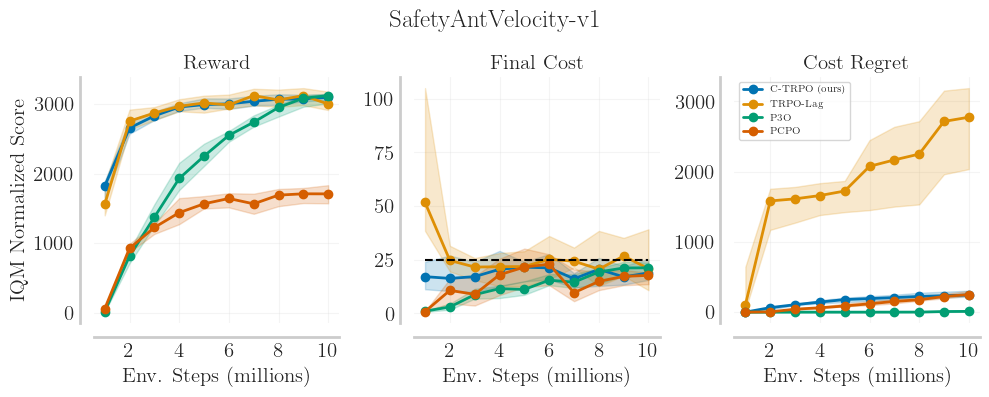

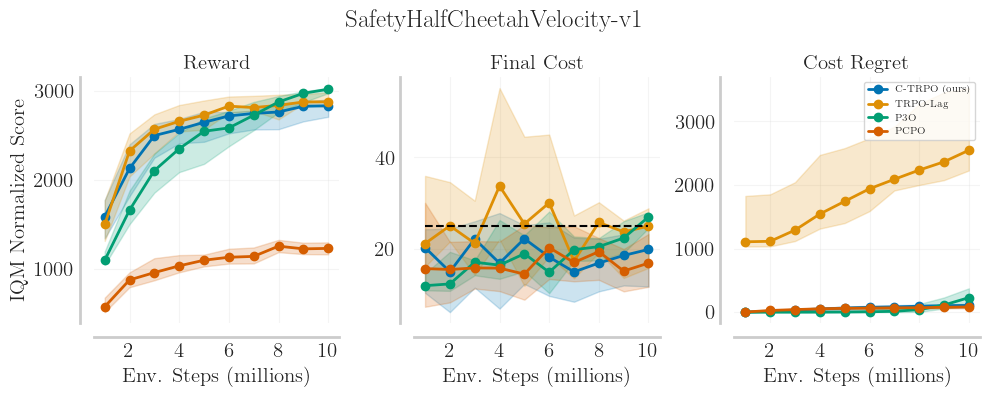

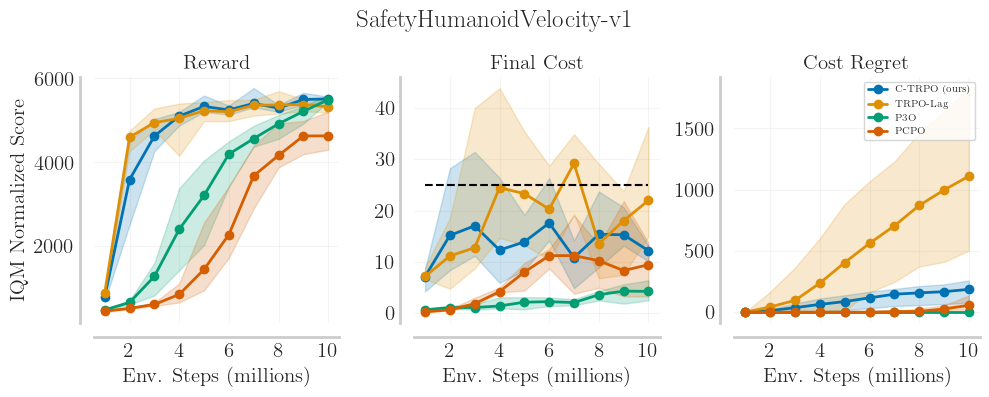

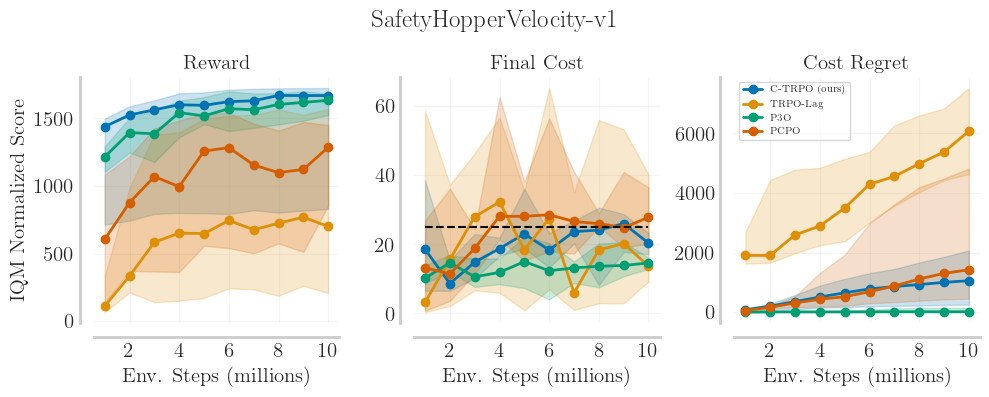

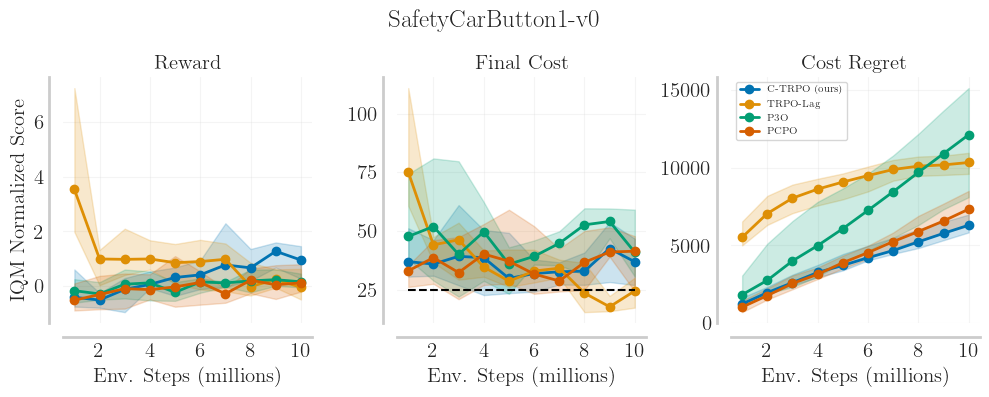

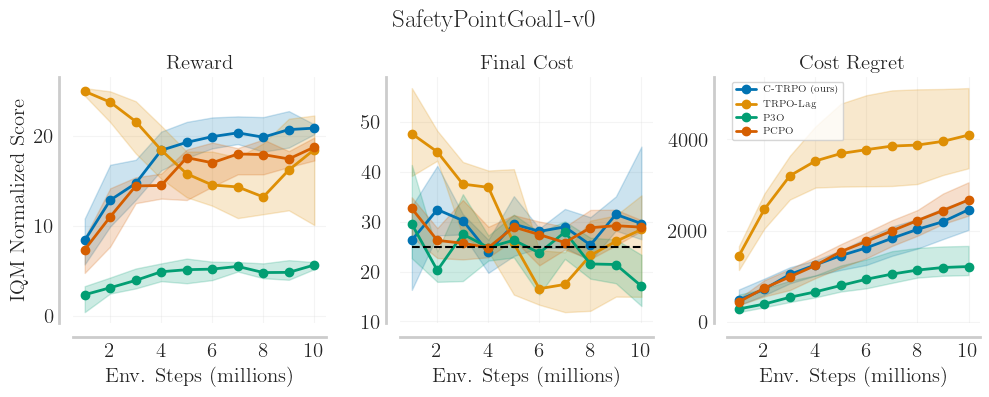

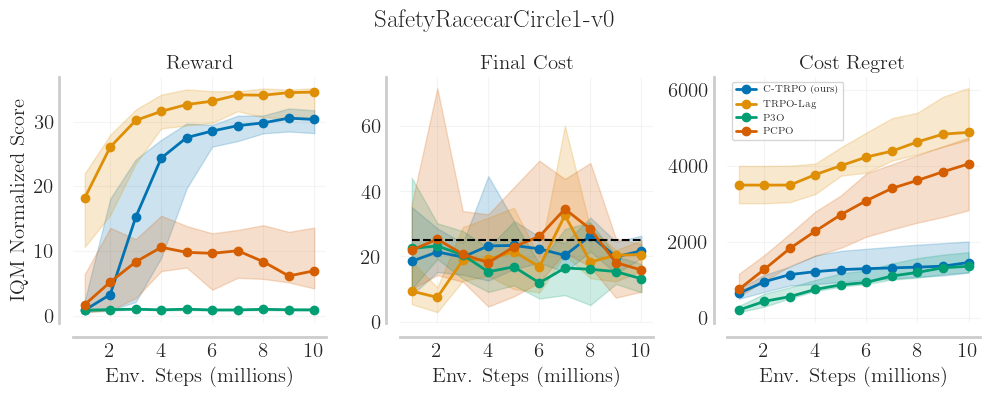

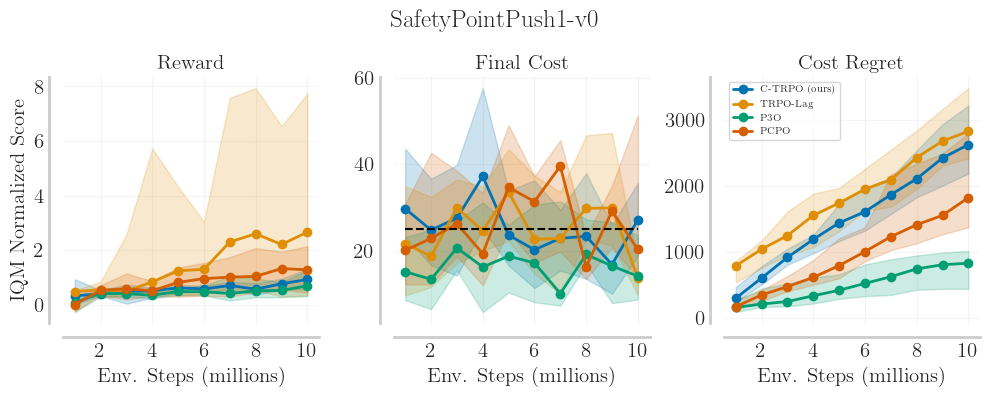

In [8]:
# we plot only the safe ones, so the plots don't get too cluttered

algos_to_plot = ALGOS[:4]

for env in ENVS:
    fig, axs = plt.subplots(1, 3, figsize=(10, 4))

    for i, (metric_name, ax) in enumerate(zip(metric_names, axs)):
        plot_utils.plot_sample_efficiency_curve(
            np.array(range(1,11)), iqm_scores[env][metric_name], iqm_cis[env][metric_name], algorithms=algos_to_plot, ax=ax,
            xlabel=r'Env. Steps (millions)',
            ylabel="IQM Normalized Score" if i == 0 else "",
            labelsize=15,
            ticklabelsize=15,
            # legend=True if (i == 0) else False,
        )

        # Cost Regret is a better term
        ax.set_title("Cost Regret" if metric_name == "Cumulative Cost" else metric_name, fontsize=15)
        ax.set_xticks([2, 4, 6, 8, 10])
    fig.suptitle(env, fontsize=18)
    
    axs[1].plot([1, 10], [25.0, 25.0], color="black", linestyle="dashed", label="limit", zorder=10)

    plt.legend(prop={'size': 7})

    plt.tight_layout()

    plt.savefig(os.path.join("..", "graphics", f"benchmark_samples_{env}.pdf"), dpi=600)